In [44]:
import os
import face_recognition
import pickle
from pathlib import Path
from os.path import join as path_join

## Configurations

In [45]:
EXTENSIONS = (".jpg", ".jpeg", ".png")

OUTPUT_PATH = path_join("output")
TRAIN_PATH = path_join("training")
VALIDATE_PATH = path_join("validation")

MODEL = "hog" # "hog" or "cnn"

DEFAULT_ENCODING_PATH = Path("output/encodings.pkl")

BOUNDING_BOX_COLOR = "blue"
TEXT_COLOR = "white"


In [46]:
Path(TRAIN_PATH).mkdir(exist_ok=True)
Path(OUTPUT_PATH).mkdir(exist_ok=True)
Path(VALIDATE_PATH).mkdir(exist_ok=True)

def encode_known_faces(model: str= MODEL, encoding_loc: Path = DEFAULT_ENCODING_PATH):
    names = []
    encodings = []
    for filepath in Path(TRAIN_PATH).glob("*/*"):
        if not str(filepath).endswith(EXTENSIONS):
            continue
        name = filepath.parent.name

        image = face_recognition.load_image_file(filepath)

        face_locations = face_recognition.face_locations(image, model=model)
        face_encodings = face_recognition.face_encodings(image, face_locations)

        for encoding in face_encodings:
            names.append(name)
            encodings.append(encoding)

    name_encodings = {"names": names, "encodings": encodings}
    with encoding_loc.open(mode="wb") as f:
        pickle.dump(name_encodings, f)

# encode_known_faces()


In [47]:
file_mapper = {
    "jpg":"images",
    "jpeg":"images",
    "jfif":"images",
    "png":"images",
    "svg":"images",
    "jpg":"images",
    "jpg":"images",
}

file_mapper.get("", path_join("misc",""))

'misc/'

taylor_swift (82, 498, 350, 230)


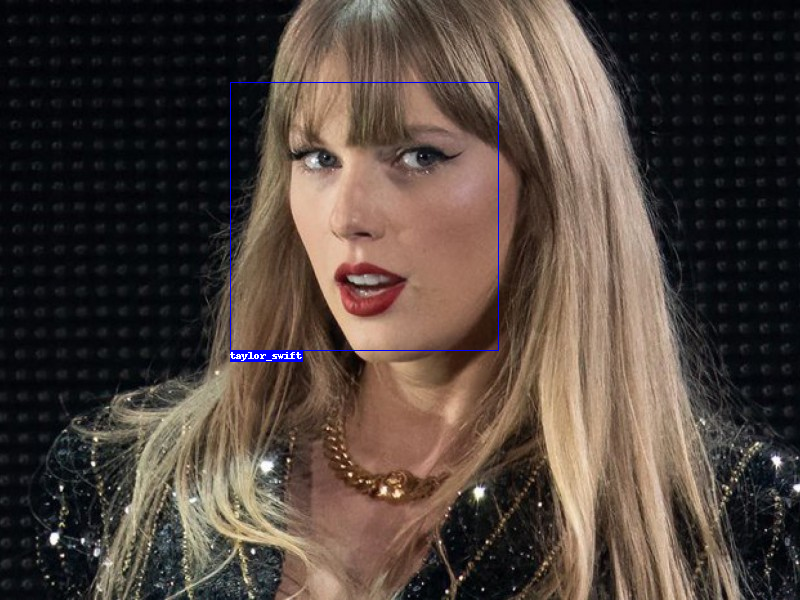

In [48]:
from collections import Counter
from PIL import Image, ImageDraw

def _recognize_face(unk_encoding, known_encodings):
    matches = face_recognition.compare_faces(known_encodings["encodings"], unk_encoding)
    votes = Counter([name for match, name in zip(matches, known_encodings["names"]) if match]) 
    
    if votes: return votes.most_common(1)[0][0]

def _display_face(draw, bounding_box, name):
    top, right, bottom, left = bounding_box
    draw.rectangle(((left, top), (right, bottom)), outline=BOUNDING_BOX_COLOR)
    
    text_left, text_top, text_right, text_bottom = draw.textbbox((left, bottom), name)

    draw.rectangle(((text_left, text_top), (text_right, text_bottom)), fill="blue", outline="blue")

    draw.text((text_left, text_top), name, fill="white")

def recognize_faces(image_loc: str, model: str = MODEL, encodings_loc: Path = DEFAULT_ENCODING_PATH):
    
    with encodings_loc.open(mode="rb") as f:
        loaded_encodings = pickle.load(f)

    input_image = face_recognition.load_image_file(image_loc)
    pillow_img = Image.fromarray(input_image)
    drawing = ImageDraw.Draw(pillow_img)

    face_locations = face_recognition.face_locations(input_image, model=model)
    face_encodings = face_recognition.face_encodings(input_image, face_locations)
    
    for bound_box, unk_encoding in zip(face_locations, face_encodings):
        name = _recognize_face(unk_encoding, loaded_encodings)
        if not name:
            name = "unknown"
        
        print(name, bound_box)
        _display_face(drawing, bound_box, name)

    del drawing 
    pillow_img.show()
recognize_faces("unknown.jpg")